In [1]:
# import packages
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import collections
import math

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from matplotlib import pyplot

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# import data
stroke_data = pd.read_csv(r'data/healthcare-dataset-stroke-data.csv')
synthetic_data = pd.read_csv(r'data/train.csv')
test_data = pd.read_csv(r'data/test.csv')
idx_data = pd.read_csv(r'data/test.csv')

# Basic Analysis  <a name="eda"></a>


In [3]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print("The features of the stroke dataset are:")
print(stroke_data.dtypes)

The features of the stroke dataset are:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [5]:
gender = stroke_data.gender.unique()
gender_types = [x for x in gender if str(x) != 'nan'] # drop nan

print(f"The gender column has only {len(gender_types)} different values: '{gender_types[0]}','{gender_types[1]} and '{gender_types[2]}'.")

The gender column has only 3 different values: 'Male','Female and 'Other'.


In [6]:
marriage = stroke_data.ever_married.unique()
marriage_column = [x for x in marriage if str(x) != 'nan'] # drop nan

print(f"The marriage column has only {len(marriage_column)} different values: '{marriage_column[0]}' and '{marriage_column[1]}'.")

The marriage column has only 2 different values: 'Yes' and 'No'.


In [7]:
work = stroke_data.work_type.unique()
work_column = [x for x in work if str(x) != 'nan'] # drop nan

print(f"The work column has only {len(work_column)} different values: '{work_column[0]}','{work_column[1]}','{work_column[2]}','{work_column[3]}' and '{work_column[4]}'.")

The work column has only 5 different values: 'Private','Self-employed','Govt_job','children' and 'Never_worked'.


In [8]:
residence = stroke_data.Residence_type.unique()
residence_column = [x for x in residence if str(x) != 'nan'] # drop nan

print(f"The residence column has only {len(residence_column)} different values: '{residence_column[0]}' and '{residence_column[1]}'.")

The residence column has only 2 different values: 'Urban' and 'Rural'.


In [9]:
smoking = stroke_data.smoking_status.unique()
smoking_column = [x for x in smoking if str(x) != 'nan'] # drop nan

print(f"The smoking column has only {len(smoking_column)} different values: '{smoking_column[0]}','{smoking_column[1]}','{smoking_column[2]}' and '{smoking_column[3]}'.")

The smoking column has only 4 different values: 'formerly smoked','never smoked','smokes' and 'Unknown'.


# Exploratory Data Analysis (EDA) <a name="eda"></a>


## 1) Univariate Analysis <a name="uni"></a>

In [10]:
stroke_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Here we can see that 201 BMI data point is missing in the main data. Also, ID column is meaningless at this point. We will drop that column when we are doing our analysis.

### distribution


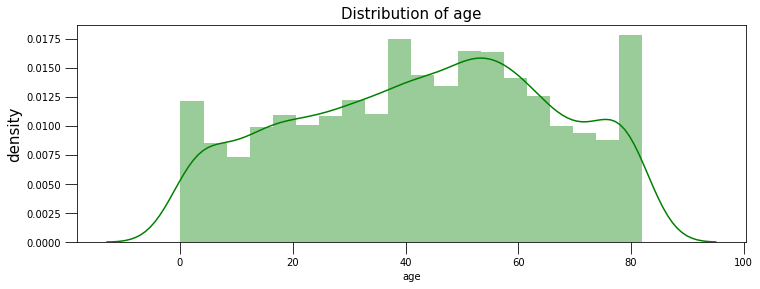

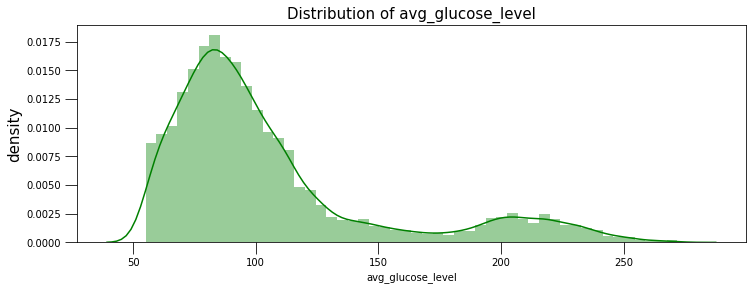

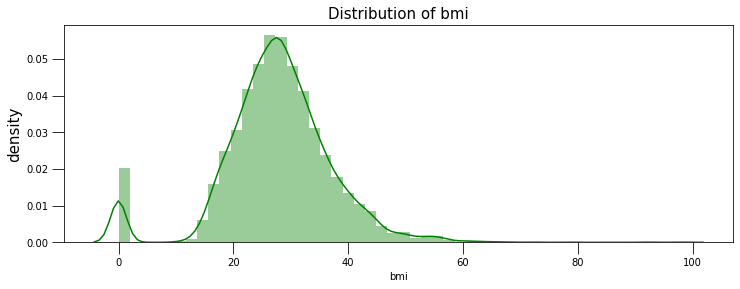

In [11]:
for col in ["age", "avg_glucose_level", "bmi"]:
    
    _, (ax1) = plt.subplots(figsize=(12,4), nrows=1, ncols=1)
    sns.distplot(stroke_data[col].fillna(0),color='g', ax=ax1)
    
    
    ax1.tick_params(size=12)
    ax1.set_ylabel("density", size=15)
        
    ax1.set_title(f"Distribution of {col}", size=15)

Here we see that age distribution is not perfect but close to uniform distribution between ages of couple of months to 82 years old.
Average glucose level distribution 'is not' similar to any distribution we know of.
Lastly, we can see that BMI data almost have a Normal distribution. Peak around must be due to data collection error since it is not possible to have BMI around 0. We will handle that data in the next steps.

In [12]:
stroke_data[(stroke_data.work_type!='children') & (stroke_data.age<=14)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
1063,42821,Female,13.0,0,0,No,Private,Rural,60.69,24.0,smokes,0
1197,26031,Female,14.0,0,0,No,Private,Rural,84.46,21.8,Unknown,0
1265,45209,Female,14.0,0,0,No,Private,Rural,118.81,24.7,Unknown,0
1789,13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0


We believe that children under the age of 14 shouldn't be working and work type column is wrong data collection. Hence, we will change those to children in the next steps including synthetic data (if there is any in the synthetic data).

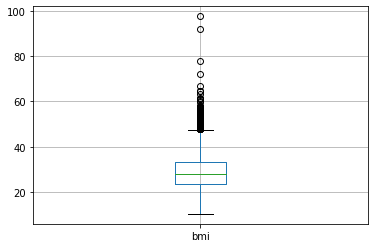

In [13]:
boxplot = stroke_data.boxplot(column=['bmi']) 

In [14]:
Q1 = stroke_data['bmi'].quantile(0.25)
Q3 = stroke_data['bmi'].quantile(0.75)
IQR = Q3 - Q1 
Max = Q3 + 1.5 *IQR 
Min = Q1 - 1.5 * IQR
print(Max)
print(Min)

47.5
9.099999999999998


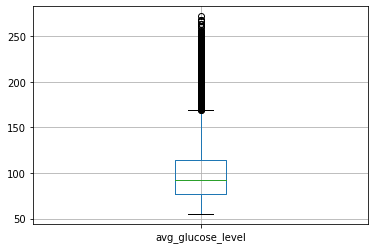

In [15]:
boxplot2 = stroke_data.boxplot(column=['avg_glucose_level']) 

In [16]:
Q1v2 = stroke_data['avg_glucose_level'].quantile(0.25)
Q3v2= stroke_data['avg_glucose_level'].quantile(0.75)
IQRv2 = Q3v2 - Q1v2 
Maxv2 = Q3v2 + 1.5 *IQRv2 
Minv2 = Q1v2 - 1.5 * IQRv2
print(Maxv2)
print(Minv2)

169.35750000000002
21.97749999999997


## 2) Bivariate Analysis <a name="uni"></a>

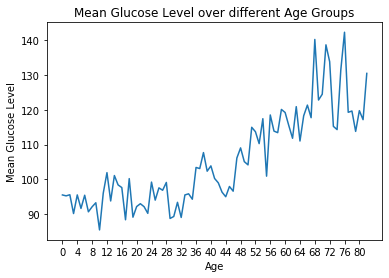

In [17]:
stroke_data.age = stroke_data.age.round()

grouped_by_age = stroke_data.groupby("age").avg_glucose_level.mean()
sns.lineplot(x = grouped_by_age.index, y = grouped_by_age)
plt.ylabel("Mean Glucose Level")
plt.xlabel("Age")
plt.xticks(np.arange(min(grouped_by_age.index), max(grouped_by_age.index)+1, 4))
plt.title("Mean Glucose Level over different Age Groups")
plt.show()

Here we can see a increasing linear trend. As people get older their Average Glucose level increases.

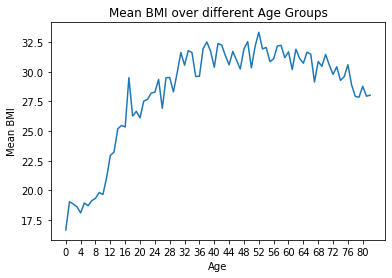

In [18]:
grouped_by_age = stroke_data.groupby("age").bmi.mean()
sns.lineplot(x = grouped_by_age.index, y = grouped_by_age)
plt.ylabel("Mean BMI")
plt.xlabel("Age")
plt.xticks(np.arange(min(grouped_by_age.index), max(grouped_by_age.index)+1, 4))
plt.title("Mean BMI over different Age Groups")
plt.show()

Here we can see a increasing linear trend followed up by a stable level. As people get older their Average BMI increases. After some age average BMI stays almost the same.

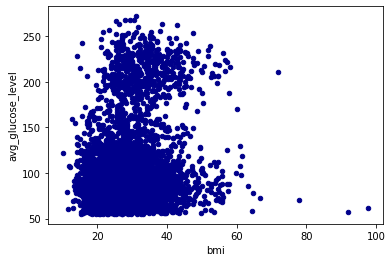

In [19]:
ax1 = stroke_data.plot.scatter(x='bmi',y='avg_glucose_level',c='DarkBlue')

In [20]:
age_grouped_stroke_rate=[]
age_grouped_stroke_rate.append(stroke_data[(0<=stroke_data.age) & (stroke_data.age<15) ].stroke.sum()/stroke_data[(0<=stroke_data.age) & (stroke_data.age<15) ].stroke.count()) 
age_grouped_stroke_rate.append(stroke_data[(15<=stroke_data.age) & (stroke_data.age<30) ].stroke.sum()/stroke_data[(15<=stroke_data.age) & (stroke_data.age<30) ].stroke.count())
age_grouped_stroke_rate.append(stroke_data[(30<=stroke_data.age) & (stroke_data.age<45) ].stroke.sum()/stroke_data[(30<=stroke_data.age) & (stroke_data.age<45) ].stroke.count())
age_grouped_stroke_rate.append(stroke_data[(45<=stroke_data.age) & (stroke_data.age<60) ].stroke.sum()/stroke_data[(45<=stroke_data.age) & (stroke_data.age<60) ].stroke.count())
age_grouped_stroke_rate.append(stroke_data[(60<=stroke_data.age) & (stroke_data.age<75) ].stroke.sum()/stroke_data[(60<=stroke_data.age) & (stroke_data.age<75) ].stroke.count())
age_grouped_stroke_rate.append(stroke_data[(75<=stroke_data.age) & (stroke_data.age<90) ].stroke.sum()/stroke_data[(75<=stroke_data.age) & (stroke_data.age<90) ].stroke.count())

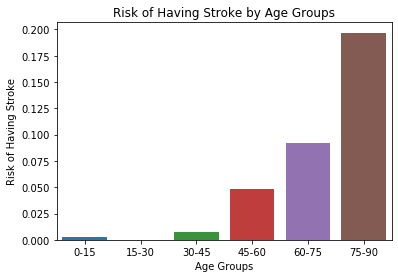

In [21]:
Limits =['0-15','15-30','30-45','45-60','60-75','75-90']
sns.barplot(x = Limits, y = age_grouped_stroke_rate)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('Age Groups')
plt.title(f"Risk of Having Stroke by Age Groups")
plt.show()

Here we can see that as people get older their risk of having a stroke increases exponentially. Hence, we can make the hypothesis that age is a significant factor for stroke.

In [22]:
glucose_grouped_stroke_rate=[]
glucose_grouped_stroke_rate.append(stroke_data[(50<=stroke_data.avg_glucose_level) & (stroke_data.avg_glucose_level<100) ].stroke.sum()/stroke_data[(50<=stroke_data.avg_glucose_level) & (stroke_data.avg_glucose_level<100) ].stroke.count()) 
glucose_grouped_stroke_rate.append(stroke_data[(100<=stroke_data.avg_glucose_level) & (stroke_data.avg_glucose_level<150) ].stroke.sum()/stroke_data[(100<=stroke_data.avg_glucose_level) & (stroke_data.avg_glucose_level<150) ].stroke.count())
glucose_grouped_stroke_rate.append(stroke_data[(150<=stroke_data.avg_glucose_level) & (stroke_data.avg_glucose_level<200) ].stroke.sum()/stroke_data[(150<=stroke_data.avg_glucose_level) & (stroke_data.avg_glucose_level<200) ].stroke.count())
glucose_grouped_stroke_rate.append(stroke_data[(200<=stroke_data.avg_glucose_level)].stroke.sum()/stroke_data[(200<=stroke_data.avg_glucose_level)].stroke.count())

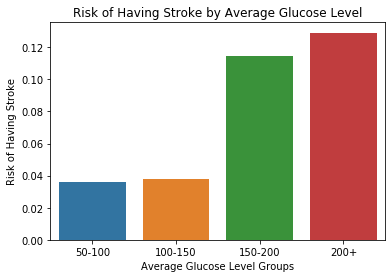

In [23]:
Limits =['50-100','100-150','150-200','200+']
sns.barplot(x = Limits, y = glucose_grouped_stroke_rate)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('Average Glucose Level Groups')
plt.title(f"Risk of Having Stroke by Average Glucose Level")
plt.show()

Here we see that, increase in the Average Glucose Level causes a jump in the risk of having a stroke. Having average glucose level above of 150 leads to almost 4 times higher risk of having a stroke

In [24]:
bmi_grouped_stroke_rate=[]
bmi_grouped_stroke_rate.append(stroke_data[(0<=stroke_data.bmi) & (stroke_data.bmi<15) ].stroke.sum()/stroke_data[(0<=stroke_data.bmi) & (stroke_data.bmi<15) ].stroke.count()) 
bmi_grouped_stroke_rate.append(stroke_data[(15<=stroke_data.bmi) & (stroke_data.bmi<30) ].stroke.sum()/stroke_data[(15<=stroke_data.bmi) & (stroke_data.bmi<30) ].stroke.count())
bmi_grouped_stroke_rate.append(stroke_data[(30<=stroke_data.bmi) & (stroke_data.bmi<45) ].stroke.sum()/stroke_data[(30<=stroke_data.bmi) & (stroke_data.bmi<45) ].stroke.count())
bmi_grouped_stroke_rate.append(stroke_data[(45<=stroke_data.bmi) ].stroke.sum()/stroke_data[(45<=stroke_data.bmi) ].stroke.count())

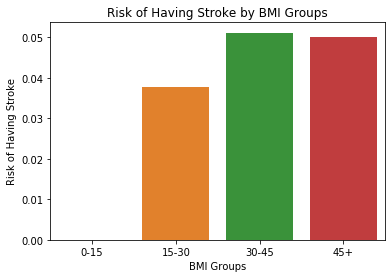

In [25]:
Limits =['0-15','15-30','30-45','45+']
sns.barplot(x = Limits, y = bmi_grouped_stroke_rate)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('BMI Groups')
plt.title(f"Risk of Having Stroke by BMI Groups")
plt.show()

The graph above shows us that BMI is also an important factor on stroke risk. 0-15 BMI group includes children, so we don't see any cases of stroke. However, among the adults, having higher BMI leads to higher risk of having a stroke.

Lastly, we can look into the risk of having a stroke by gender, work type, residence type and smoking status.

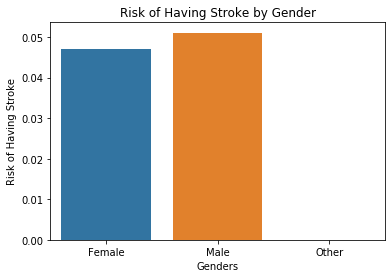

In [26]:
grouped_by_gender = stroke_data.groupby("gender").stroke.sum()/stroke_data.groupby("gender").stroke.count()
grouped_by_gender = stroke_data.groupby("gender").stroke.sum()/stroke_data.groupby("gender").stroke.count()

Limits =['Female','Male','Other']
sns.barplot(x = Limits, y = grouped_by_gender)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('Genders')
plt.title(f"Risk of Having Stroke by Gender")
plt.show()

Here we can see that Males have higher chance of having a stroke. Other genders only have 1 data so it is not representative. For the future analysis we will drop Other genders.

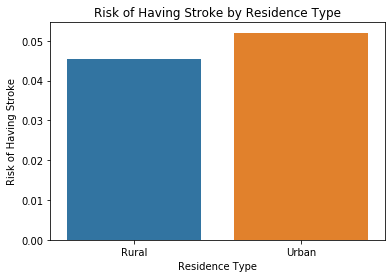

In [27]:
grouped_by_residence = stroke_data.groupby("Residence_type").stroke.sum()/stroke_data.groupby("Residence_type").stroke.count()

Limits =['Rural','Urban']
sns.barplot(x = Limits, y = grouped_by_residence)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('Residence Type')
plt.title(f"Risk of Having Stroke by Residence Type")
plt.show()

Here we can see that people living in Urban areas have higher chance of having a stroke.

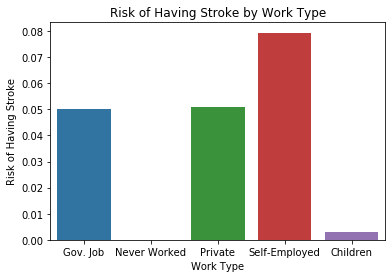

In [28]:
grouped_by_work = stroke_data.groupby("work_type").stroke.sum()/stroke_data.groupby("work_type").stroke.count()

Limits =['Gov. Job','Never Worked','Private','Self-Employed','Children']
sns.barplot(x = Limits, y = grouped_by_work)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('Work Type')
plt.title(f"Risk of Having Stroke by Work Type")
plt.show()

In [29]:
stroke_data[stroke_data.work_type=='Never_worked'].age.mean()

16.181818181818183

Here, we see that Never worked and children have very low rate of stroke risk. Additional analysis shows that Never worked people have average age of 16.18. Hence we can group children and never worked together for the future analysis as both represents very young people.

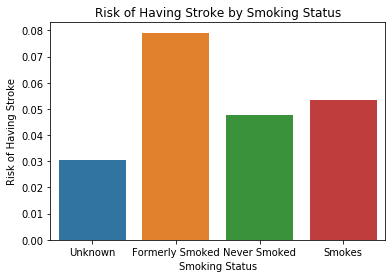

In [30]:
grouped_by_smoking = stroke_data.groupby("smoking_status").stroke.sum()/stroke_data.groupby("smoking_status").stroke.count()

Limits =['Unknown','Formerly Smoked','Never Smoked','Smokes']
sns.barplot(x = Limits, y = grouped_by_smoking)
plt.xticks(rotation=0)
plt.ylabel("Risk of Having Stroke")
plt.xlabel('Smoking Status')
plt.title(f"Risk of Having Stroke by Smoking Status")
plt.show()

Here we can see that smoking at one point in life increases the risk of a stroke.

# Data Wrangling  <a name="eda"></a>


In [31]:
train_data = pd.concat([stroke_data, synthetic_data], axis=0)

In [32]:
train_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


In [33]:
train_data.isna().any(axis=1).sum()

201

There are 201 data points with NaN values. Since it is lower than 1% of all data we can simply drop that data. Another way would be syntheticly replacing Nan values with mean or median but it would introduce bias to the data. Hence, we choose to drop rows with NaN values.

In [34]:
train_data = train_data.dropna()
train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)
train_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


#### One hot Encoding

In [35]:
categorical_features = ['gender','ever_married','work_type','Residence_type','smoking_status']
for categorical_feature in categorical_features:
    one_hot_train = pd.get_dummies(train_data[categorical_feature])
    one_hot_test = pd.get_dummies(test_data[categorical_feature])
    train_data = train_data.drop([categorical_feature], axis=1)
    test_data = test_data.drop([categorical_feature], axis=1)
    train_data = pd.concat([train_data, one_hot_train], axis=1)
    test_data = pd.concat([test_data, one_hot_test], axis=1)

In [36]:
train_data = train_data.drop(['Other','No','Never_worked','Urban','Unknown'], axis=1)
test_data = test_data.drop(['Other','No','Never_worked','Urban','Unknown'], axis=1) 

We drop one column coming from each categorical variable. For example, in the case of gender column if both female and male is 0 it means other must be 1. Hence, we can drop Other column as it doesn't provide any statistical information.

#### Imbalanced Data and Oversampling of Minority group

In [37]:
train_data.stroke.sum()/train_data.stroke.count() ### imbalanced data - look at smote

0.04160688665710186

Here we see that only 4% of the data had a stroke. This is very small percentage for supervised learning to learn from data. Hence, we need to oversample minority group.

In [38]:
X_train = train_data.drop(['stroke'], axis=1)
y_train = train_data.stroke

In [39]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

After oversampling, we now have 50% of the data stroke and other half no stroke.

# Model Selection (Classification Models) <a name="eda"></a>


#### Logistic Regression

In [40]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','l1']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression(solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_train_res, y_train_res)

print('-----')
print(f'Best parameters {clf1.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{clf1.best_score_:.3f}'
)
print('-----')

LR_Results= pd.DataFrame(clf1.cv_results_)[['param_C','param_penalty','mean_test_score']]
clf1_pivot = LR_Results.pivot('param_C', 'param_penalty')
clf1_pivot

-----
Best parameters {'C': 100, 'penalty': 'l1'}
Mean cross-validated accuracy score of the best_estimator: 0.912
-----


mean_test_score          
param_penalty              l1        l2
param_C                                
0.001                0.815198  0.860443
0.010                0.906876  0.905482
0.100                0.911625  0.911341
1.000                0.912090  0.912142
10.000               0.912167  0.912013
100.000              0.912193  0.912090
1000.000             0.912142  0.912090

#### Decision Tree Classifier

In [41]:
DTSplitList=[0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-6)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train_res, y_train_res)

print('-----')
print(f'Best parameters {clf2.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{clf2.best_score_:.3f}'
)
print('-----')

DTC_Results= pd.DataFrame(clf2.cv_results_)[['param_criterion','param_max_depth','param_min_samples_leaf','param_min_samples_split','mean_test_score']]

-----
Best parameters {'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 0.025, 'min_samples_split': 0.01}
Mean cross-validated accuracy score of the best_estimator: 0.851
-----


#### Random Forest Classifier

In [42]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train_res, y_train_res)

print('-----')
print(f'Best parameters {clf3.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{clf3.best_score_:.3f}'
)
print('-----')

RFC_Results= pd.DataFrame(clf3.cv_results_)[['param_criterion','param_max_depth','param_n_estimators','mean_test_score']]

-----
Best parameters {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 200}
Mean cross-validated accuracy score of the best_estimator: 0.969
-----


#### XGBoost Classifier

In [43]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [2, 3],
    'learning_rate': [ 0.01, 0.02],
    'subsample': [0.4, 0.6]
}
clf4 = GridSearchCV(XGBClassifier(silent=False,random_state=10), params, scoring ='accuracy')
clf4.fit(X_train_res, y_train_res)

print('-----')
print(f'Best parameters {clf4.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{clf4.best_score_:.3f}'
)
print('-----')

-----
Best parameters {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.4}
Mean cross-validated accuracy score of the best_estimator: 0.901
-----


Best model is Random Forest Classifier with parameters 'criterion': 'gini', 'max_depth': 100, 'n_estimators': 200. We will use those paramaters to predict stroke on test data.

# Prediction of Stroke<a name="eda"></a>


In [44]:
y_test_pred = clf3.predict(test_data)

pred_data = pd.DataFrame(y_test_pred, columns = ['stroke'])
pred_data['id']=idx_data.id
pred_data = pred_data.reindex(sorted(pred_data.columns), axis=1)
pred_data.to_csv("prediction.csv",index=False)